In [ ]:
!pip install tensorflow-io

     |████████████████████████████████| 22.7 MB 84.7 MB/s 
     |████████████████████████████████| 2.3 MB 46.5 MB/s 


In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 679 kB 12.9 MB/s 


In [ ]:
# Importing the necessary libraries
import tensorflow as tf
import tensorflow_io as tfio
import tensorflow_addons as tfa
import pandas as pd  
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
#from classification_models.keras import Classifiers
from sklearn.metrics import label_ranking_average_precision_score

from PIL import Image
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
#Global variables
img_ht=384
img_wt=768
sample_rate=48000
num_class=24
num_mels=384
f_min=40
f_max=24000
batch_size=8
#(train_pts/batch_size)
steps_per_epoch=140 

In [ ]:
# Loading the dataset 
train_tp=pd.read_csv('/content/drive/MyDrive/Appliedai files/Case_Study_2/train_tp.csv')

In [ ]:
# Loading the test data files
test = os.listdir('/content/drive/MyDrive/Appliedai files/Case_Study_2/test')

In [ ]:
# Splitting the train true positive data into train and validation
train, validation = train_test_split(train_tp, test_size = 0.1, stratify = train_tp['species_id'])

In [ ]:
#https://www.tensorflow.org/io/tutorials/audio?hl=pt

def create_mel_spectrogram(file):

    """ This function reads the file and computes the mel spectrogram and returns the spectrogram"""
    audio = tfio.IOTensor.graph(tf.int16).from_audio(file)
    audio_slice = audio[100:]

    # remove last dimension
    audio_tensor = tf.squeeze(audio_slice, axis=[-1])
    audio_tensor = tf.cast(audio_tensor, tf.float32)

    # Convert to spectrogram
    spectrogram = tfio.audio.spectrogram(audio_tensor, nfft=2048, window=2048, stride=512)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sample_rate, mels=num_mels, fmin=f_min, fmax=f_max)
    mel_spectrogram = tfio.audio.dbscale(mel_spectrogram, top_db=80)

    # Expanding the dimensions of spectrograms by 1 
    image = tf.expand_dims(mel_spectrogram, axis= -1)
    image = tf.image.resize(image, [img_ht, img_wt])
    image = tf.image.grayscale_to_rgb(image)

    # Returning mel_spectrogram
    return image


In [ ]:
#https://www.tensorflow.org/tutorials/images/data_augmentation

def augmentation(spectrogram,label):

  #in this function we perform data augmentations on the spectrogram images for train data
  
  k=np.random.uniform()
  if k<0.25:
    spectrogram = tf.image.flip_up_down(spectrogram)

  elif k<0.5:
    spectrogram= tf.image.flip_left_right(spectrogram)

  elif k<0.75:
    spectrogram= tf.image.random_contrast(spectrogram,0.2,0.5)

  else:
    spectrogram = tf.image.random_brightness(spectrogram,0.2)

  return spectrogram,label

In [ ]:
def preprocess_train(file):

  #Preprocessing the train data

  image=create_mel_spectrogram('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+file['recording_id']+'.flac')

  #one hot encoding of the target labels
  label= tf.one_hot(file['species_id'],num_class)

  return image,label

def preprocess_val(file):

  #Preprocessing the validation data

  image=create_mel_spectrogram('/content/drive/MyDrive/Appliedai files/Case_Study_2/train/'+file['recording_id']+'.flac')

  #one hot encoding of the target labels
  label= tf.one_hot(file['species_id'],num_class)

  return image,label


def preprocess_test(file):

  #Preprocessing the test data

  image=create_mel_spectrogram('/content/drive/MyDrive/Appliedai files/Case_Study_2/test/'+file)

  #getting the file ids
  file_name=tf.strings.split(file,'.')[0]

  return image,file_name


In [ ]:
# Creating a dataset from train data and mapping the preprocess train function 
files_ds = tf.data.Dataset.from_tensor_slices(dict(train))
train_dataset = files_ds.map(preprocess_train).cache().map(augmentation).shuffle(3).batch(batch_size).prefetch(-1).repeat()

# Creating a dataset from validation data and mapping the preprocess val function 
files_ds = tf.data.Dataset.from_tensor_slices(dict(validation))
val_dataset = files_ds.map(preprocess_val).cache().shuffle(3).batch(batch_size).prefetch(-1)

# Creating a dataset from test data and mapping the preprocess test function
files_ds = tf.data.Dataset.from_tensor_slices(test)
test_dataset = files_ds.map(preprocess_test).cache().shuffle(3).prefetch(-1)

In [ ]:
def lwlrap(y_true, y_pred):
    return tf.py_function(label_ranking_average_precision_score, (y_true, y_pred), tf.double)

In [ ]:
backbone = tf.keras.applications.EfficientNetB3(include_top = False,input_shape = (img_ht,img_wt,3), weights="imagenet")

for layer in backbone.layers[:0]:
    layer.trainable = False

model = tf.keras.Sequential([
            backbone,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(128, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()),
            tf.keras.layers.Dropout(0.5),
            #tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(num_class,bias_initializer=tf.keras.initializers.Constant(-2.))])

model.summary()

43941888/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb3 (Functional)  (None, 12, 24, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                3096      
Total params: 10,983,367
Trainable params: 10,896,064
Non-trainable params: 87,303
_________________________________________________________________


In [ ]:
model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=2e-3,total_steps=30*140,warmup_proportion=0.3,min_lr=1e-6), loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits = True), metrics=[lwlrap])

In [ ]:
#loading tensorboard
%load_ext tensorboard
!rm -rf ./logs/
from datetime import datetime
#creating log directory
logdir="logs/scalars_1/" + datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard callback
tensorboard_1 = tf.keras.callbacks.TensorBoard(log_dir=logdir)
earlystop=tf.keras.callbacks.EarlyStopping(monitor='val_lwlrap',patience=8,mode='max')

#Path for saving model
filepath="/content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-{epoch:02d}-{val_lwlrap:.4f}.hdf5"
#Model checkpoint callback
checkpoint_1 = tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_lwlrap', save_best_only=True, verbose=1, mode='max', save_freq='epoch')


In [ ]:
model.fit(train_dataset,steps_per_epoch=steps_per_epoch, validation_data=val_dataset,epochs = 50,callbacks = [tensorboard_1,earlystop,checkpoint_1])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/50
140/140 [==============================] - 2670s 18s/step - loss: 0.4376 - lwlrap: 0.1891 - val_loss: 0.4509 - val_lwlrap: 0.1633

Epoch 00001: val_lwlrap improved from -inf to 0.16326, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-01-0.1633.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
140/140 [==============================] - 106s 758ms/step - loss: 0.3855 - lwlrap: 0.2931 - val_loss: 0.4367 - val_lwlrap: 0.1729

Epoch 00002: val_lwlrap improved from 0.16326 to 0.17294, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-02-0.1729.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/50
140/140 [==============================] - 106s 759ms/step - loss: 0.3450 - lwlrap: 0.4163 - val_loss: 0.4141 - val_lwlrap: 0.2229

Epoch 00003: val_lwlrap improved from 0.17294 to 0.22293, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-03-0.2229.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/50
140/140 [==============================] - 106s 758ms/step - loss: 0.3132 - lwlrap: 0.5049 - val_loss: 0.3546 - val_lwlrap: 0.4068

Epoch 00004: val_lwlrap improved from 0.22293 to 0.40676, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-04-0.4068.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/50
140/140 [==============================] - 106s 756ms/step - loss: 0.3033 - lwlrap: 0.5563 - val_loss: 0.3316 - val_lwlrap: 0.4643

Epoch 00005: val_lwlrap improved from 0.40676 to 0.46432, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-05-0.4643.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 6/50
140/140 [==============================] - 106s 757ms/step - loss: 0.2976 - lwlrap: 0.5701 - val_loss: 0.3375 - val_lwlrap: 0.5194

Epoch 00006: val_lwlrap improved from 0.46432 to 0.51937, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-06-0.5194.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 7/50
140/140 [==============================] - 106s 758ms/step - loss: 0.3211 - lwlrap: 0.5230 - val_loss: 0.4661 - val_lwlrap: 0.3453

Epoch 00007: val_lwlrap did not improve from 0.51937
Epoch 8/50
140/140 [==============================] - 106s 757ms/step - loss: 0.3255 - lwlrap: 0.5019 - val_loss: 0.3368 - val_lwlrap: 0.4762

Epoch 00008: val_lwlrap did not improve from 0.51937
Epoch 9/50
140/140 [==============================] - 106s 758ms/step - loss: 0.3038 - lwlrap: 0.5768 - val_loss: 0.4999 - val_lwlrap: 0.2247

Epoch 00009: val_lwlrap did not improve from 0.51937
Epoch 10/50
140/140 [==============================] - 106s 758ms/step - loss: 0.3204 - lwlrap: 0.5236 - val_loss: 0.4551 - val_lwlrap: 0.3730

Epoch 00010: val_lwlrap did not improve from 0.51937
Epoch 11/50
140/140 [==============================] - 106s 758ms/step - loss: 0.2837 - lwlrap: 0.5971 - val_loss: 0.3316 - val_lwlrap: 0.4837

Epoch 00011: val_lwlrap did not improve from 0.51937
Epoch 12/50
140/14

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 15/50
140/140 [==============================] - 107s 762ms/step - loss: 0.1992 - lwlrap: 0.7638 - val_loss: 0.3544 - val_lwlrap: 0.5638

Epoch 00015: val_lwlrap did not improve from 0.57525
Epoch 16/50
140/140 [==============================] - 106s 760ms/step - loss: 0.1956 - lwlrap: 0.7716 - val_loss: 0.3405 - val_lwlrap: 0.6149

Epoch 00016: val_lwlrap improved from 0.57525 to 0.61490, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-16-0.6149.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 17/50
140/140 [==============================] - 106s 758ms/step - loss: 0.1641 - lwlrap: 0.8218 - val_loss: 0.4233 - val_lwlrap: 0.5199

Epoch 00017: val_lwlrap did not improve from 0.61490
Epoch 18/50
140/140 [==============================] - 106s 758ms/step - loss: 0.1733 - lwlrap: 0.8108 - val_loss: 0.3480 - val_lwlrap: 0.5919

Epoch 00018: val_lwlrap did not improve from 0.61490
Epoch 19/50
140/140 [==============================] - 106s 755ms/step - loss: 0.1556 - lwlrap: 0.8446 - val_loss: 0.3982 - val_lwlrap: 0.5534

Epoch 00019: val_lwlrap did not improve from 0.61490
Epoch 20/50
140/140 [==============================] - 106s 757ms/step - loss: 0.1249 - lwlrap: 0.8815 - val_loss: 0.3271 - val_lwlrap: 0.6113

Epoch 00020: val_lwlrap did not improve from 0.61490
Epoch 21/50
140/140 [==============================] - 106s 759ms/step - loss: 0.1034 - lwlrap: 0.9166 - val_loss: 0.4272 - val_lwlrap: 0.6407

Epoch 00021: val_lwlrap improved from 0.61490 to 0.64074, saving mod

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 22/50
140/140 [==============================] - 106s 758ms/step - loss: 0.0948 - lwlrap: 0.9255 - val_loss: 0.3775 - val_lwlrap: 0.6786

Epoch 00022: val_lwlrap improved from 0.64074 to 0.67859, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-22-0.6786.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 23/50
140/140 [==============================] - 106s 760ms/step - loss: 0.0656 - lwlrap: 0.9458 - val_loss: 0.4598 - val_lwlrap: 0.6595

Epoch 00023: val_lwlrap did not improve from 0.67859
Epoch 24/50
140/140 [==============================] - 107s 762ms/step - loss: 0.0565 - lwlrap: 0.9569 - val_loss: 0.3832 - val_lwlrap: 0.6821

Epoch 00024: val_lwlrap improved from 0.67859 to 0.68208, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-24-0.6821.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 25/50
140/140 [==============================] - 106s 761ms/step - loss: 0.0418 - lwlrap: 0.9738 - val_loss: 0.5013 - val_lwlrap: 0.6904

Epoch 00025: val_lwlrap improved from 0.68208 to 0.69039, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-25-0.6904.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 26/50
140/140 [==============================] - 106s 760ms/step - loss: 0.0352 - lwlrap: 0.9754 - val_loss: 0.4941 - val_lwlrap: 0.6915

Epoch 00026: val_lwlrap improved from 0.69039 to 0.69151, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-26-0.6915.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 27/50
140/140 [==============================] - 106s 760ms/step - loss: 0.0282 - lwlrap: 0.9852 - val_loss: 0.4911 - val_lwlrap: 0.7256

Epoch 00027: val_lwlrap improved from 0.69151 to 0.72560, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-27-0.7256.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 28/50
140/140 [==============================] - 106s 758ms/step - loss: 0.0238 - lwlrap: 0.9852 - val_loss: 0.5766 - val_lwlrap: 0.7329

Epoch 00028: val_lwlrap improved from 0.72560 to 0.73290, saving model to /content/drive/MyDrive/Appliedai files/Case_Study_2/CS2_modelling2/model_1/weights-28-0.7329.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 29/50
140/140 [==============================] - 106s 758ms/step - loss: 0.0193 - lwlrap: 0.9919 - val_loss: 0.5876 - val_lwlrap: 0.7165

Epoch 00029: val_lwlrap did not improve from 0.73290
Epoch 30/50
140/140 [==============================] - 106s 760ms/step - loss: 0.0168 - lwlrap: 0.9934 - val_loss: 0.5688 - val_lwlrap: 0.7284

Epoch 00030: val_lwlrap did not improve from 0.73290
Epoch 31/50
140/140 [==============================] - 106s 759ms/step - loss: 0.0184 - lwlrap: 0.9889 - val_loss: 0.5726 - val_lwlrap: 0.7245

Epoch 00031: val_lwlrap did not improve from 0.73290
Epoch 32/50
140/140 [==============================] - 106s 761ms/step - loss: 0.0155 - lwlrap: 0.9932 - val_loss: 0.5575 - val_lwlrap: 0.7086

Epoch 00032: val_lwlrap did not improve from 0.73290
Epoch 33/50
140/140 [==============================] - 106s 759ms/step - loss: 0.0160 - lwlrap: 0.9914 - val_loss: 0.5621 - val_lwlrap: 0.7097

Epoch 00033: val_lwlrap did not improve from 0.73290
Epoch 34/50
140

In [ ]:
%tensorboard --logdir /content/logs/scalars_1

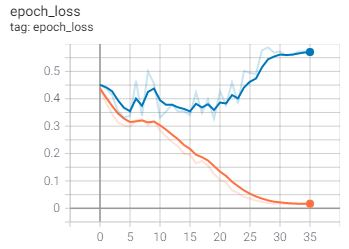

In [1]:
#Loss and metric plots

from IPython.display import Image
Image(filename='/content/drive/MyDrive/EffnetB3_loss.JPG')

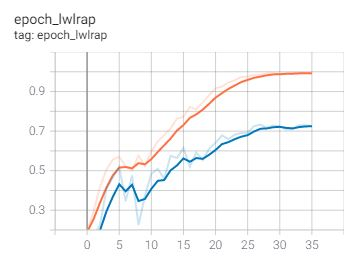

In [3]:

Image(filename='/content/drive/MyDrive/EffnetB3_metric.JPG')